# Practical Concepts in Machine Learning

-----

In this IPython Notebook, we explore several practical concepts that extend previous machine learning techniques to support more powerful analyses. As a result, these concepts can be very important in real-world machine learning applications. The three specific concepts we explore in this notebook include:

2. Voting Classifier
3. Pipelines
5. Multi-Output Regression

-----

## Table of Contents

[Voting Classification](#Voting-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Voting Classification: Decision Surface](#Voting-Classification:-Decision-Surface)
- [Classification: Adult Data](#Classification:-Adult-Data)

[Pipeline](#Pipeline)
- [Regression: Auto MPG Data](#Auto-MPG-Data)
- [Pipeline: Regression](#Pipeline:-Regression)

[Regression: Multi-Output](#Regression:-Multi-Output)

-----

Before proceeding with the rest of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook
%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Voting Classification

To this point, we have introduced a number of different algorithms for performing classification, both for binary decisions, as well as multi-output classification decisions. These algorithms have included logistic regression, support vector classification, decision trees, and bagging and boosting ensemble techniques. A third form of ensemble learning is to simply combine the predictions from standard algorithms by using a voting process. This voting process can be simple, where majority rules, or more complex, where probabilistic values are used in the voting process, or weights can be assigned (or computed) to favor better performing algorithms. The goal of this approach is to use different algorithms that can complement each other so that the final result is an improved meta-classifier.

The scikit-learn library supports this technique through the [`VotingClassifier`][skvc] ensemble estimator. This estimator is, by default, constructed by specifying two hyperparameters: `estimators` and `voting`. The first hyperparameter, `estimator`, accepts a list that contains the classification algorithms to be used in the voting process. This list should contain tuples that map a name, provided as a string, to the relevant scikit learn classification estimator. The second hyperparameter, `voting`, indicates the type of voting process to use across the input estimators to determine the final classification.

The voting approaches supported include the following:
- `hard`: majority voting based on input classifications.
- `soft`: majority voting on summed classification probabilities.

A third hyperparameter, `weights`, can be used to weight either of the two voting approaches. These weights can be specified from prior information or computed from the data directly (perhaps via a validation step, described in a future notebook). For hard voting, the weights just adjust the weight of each classifier’s vote. For soft voting, the weights adjust the probabilistic classification from each algorithm before the class probabilities are summed.

To demonstrate using a voting classifier with the scikit-learn library, we will first load in the Iris data. With these data, we will construct a k-nearest neighbor classifier, a logistic regression classifier, and a random forest classifier, and compute a soft vote over the probabilistic outputs from these three algorithms. Next, we will look at the decision surface for the input algorithms and the voting classifier as applied to the Iris data. Finally, we will switch to a larger data set to learn how to employ a decision tree on more complex data.

----
[skvc]: http://scikit-learn.org/stable/modules/ensemble.html#voting-classifier


[[Back to TOC]](#Table-of-Contents)

### Classification:  Iris Data

We can now apply the Voting Classification algorithm to the Iris data to create an ensemble classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import our estimator, [`VotingClassifier`][skvc], from the proper scikit-learn module, `ensemble`, as well as any input classification algorithms we wish to include in the voting process.
2. Create the input classification estimators, and pass them into the voting classification estimator as a hyperparameter.
3. Fit the voting ensemble model to the training data, which by default fits each individual estimator in the voting ensemble to the training data as well. Note, by using our simple `get_iris_data` helper function we have loaded the Iris data, split the data into training and testing sets, and scaled all data by first normalizing the training data.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a classification report).

These steps are demonstrated in the following three Code cells, where we obtain our data, create our estimator, fit the estimator to our training data, and generate a classification report on the testing data. 

-----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [2]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.25

# Do not show the 'Train' and 'Test' data plot.
show_plot = False

# Split data into training and testing
# Note that we have both 'data' and 'labels'
d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)

In [3]:
# Apply voting classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Create input estimators
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = LogisticRegression(random_state=23)
clf3 = RandomForestClassifier(random_state=23)

# Create a list of tuples, matching name to input estimator
estl = [('knn', clf1), ('lr', clf2),('rfc', clf3)]

vclf = VotingClassifier(estimators=estl, voting='soft')

# Fit the training data
vclf = vclf.fit(d_train_sc, l_train)

In [4]:
from sklearn.metrics import classification_report

score = 100.0 * vclf.score(d_test_sc, l_test)
print(f"Voting prediction accuracy = {score:5.1f}%")

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = vclf.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

Voting prediction accuracy =  97.4%
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        16
  Versicolor       0.92      1.00      0.96        11
   Virginica       1.00      0.91      0.95        11

   micro avg       0.97      0.97      0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we created a voting classifier that employed _soft_ voting and displayed the classification report. Now that you have run the example, try making the following changes and see how the results vary.

2. Employ a _hard_ voting scheme. The values of `max_depth` to 4, 8, and 12.
3. Employ a _soft_ voting scheme, but weight the input algorithms as follows: k-nn with weight one, logistic regression with weight two, and random forest with weight four.

-----

[[Back to TOC]](#Table-of-Contents)

### Voting Classification: Decision Surface

-----

While the classification report is useful in providing a summary of the performance of the voting classifier, a more intuitive result is provided by looking at the decision surface for the input algorithms and the voting classifier. In the following Code cell, we first trim the Iris data to two features: Sepal Width and Petal Width. Next, we construct a mesh grid of data points spanning the allowed ranges over these two features. Next, we loop over our three input classification estimators and our voting classifier, applying each estimator to these data and the mesh grid before displaying the result. Note that we have, in general, used the default hyperparameters for the three input algorithms.

As the resulting figures demonstrate, the three input algorithms have widely different decision surfaces. This is interesting, in part, since this is a simple data set, but also because this demonstrates how the different algorithms partition the data to build a classification model. The final figure shows the result from a _soft_ voting process, and looks to be a combination, as expected, from all three input classification algorithms.

-----

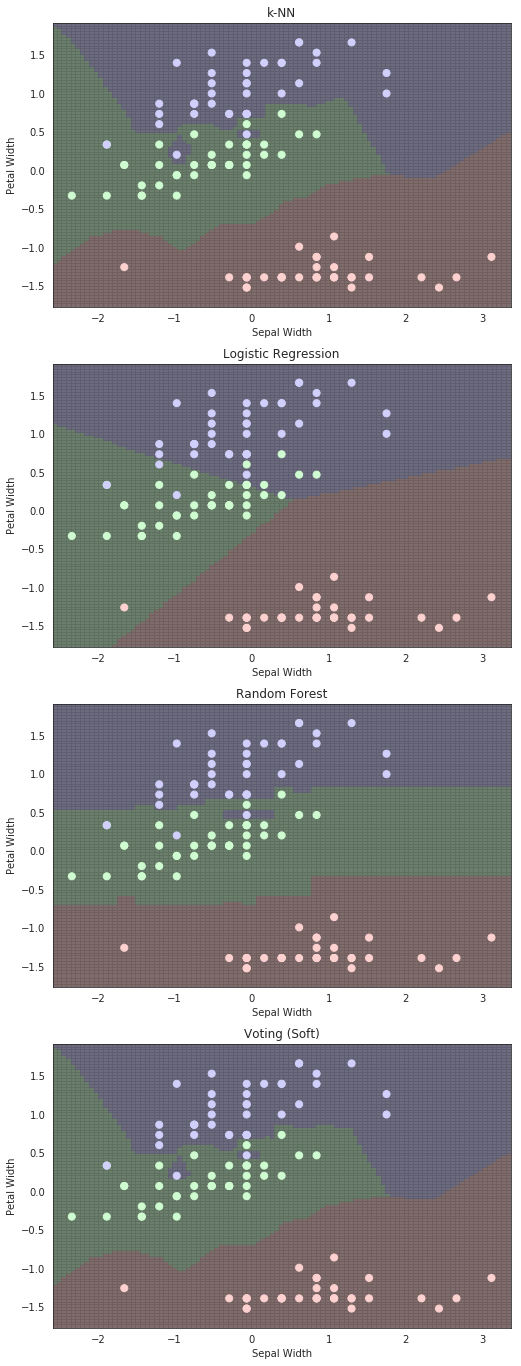

In [5]:
# Titles for the figures
titles = ['k-NN', 'Logistic Regression', 'Random Forest','Voting (Soft)']

# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

# Show the mesh grid and training data
fig, axs = plt.subplots(figsize=(10, 6 * len(titles)), 
                        nrows=len(titles), ncols=1, 
                        sharex=False)

# Iterate through different neighbor counts
for idx, clf in enumerate([clf1, clf2, clf3, vclf]):
    
    # Now train our model
    clf.fit(n_data[:,:2], n_data[:,2])
    
    # Predict for mesh grid
    z = clf.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'{titles[idx]}')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we generated decision surfaces for three different classification algorithms, and the voting classification that employed _soft_ voting over these three algorithms. In the previous Code cell, try making the following changes and think about what you can learn from the new decision surfaces. 

2. Change the voting to use _hard_ voting.
23. Use _soft_ voting, but with weights equal to 1, 2, and 4 for the k-nearest neighbor, logistic regression, and random forest classification algorithms.
4. Try changing the hyperparameters for the input algorithms, such as the number of nearest neighbors, or the maximum depth of the random forest.

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now turn to a more complex data set with which to perform ensemble voting classification, the [Adult income prediction task][uciad]. These data have been discussed in detail in other notebooks, especially in the _Introduction to Decision Trees_. The task is to predict from census data whether an individual makes more than $50,000.

In the following two Code cells, we first build a full path and file name for where this data will be stored locally. Next, we check to see if the data is already available locally, and if not, we use the `wget` command to pull the data from the UCI machine learning repository for local analysis.

-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [6]:
# Adult data file from UCI ML Repository
# http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# First we find our HOME directory
tmp = !echo $HOME

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/adult.data'

In [7]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

Now that the _adult data_ has been stored locally, we can read the data into a DataFrame and begin pre-processing it to enable the application of a decision tree for classification. To do this, we first use the pandas `read_csv` function to read the local file. We explicitly define the column names, and indicate that the columns are delimited by white space. Once the DataFrame is created, we randomly sample five rows to verify that the data has been successfully read.

-----

In [8]:
# Adult data archived at UCI ML Repository

col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data from URL return Pandas
adult_data = pd.read_csv(data_file, index_col=False, names = col_names)

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Now we can drop the original column
adult_data = adult_data.drop('Salary', axis=1)

# Define categorical features
categorical = ['Education', 'Workclass', 'Race', 'Sex', 'Occupation', 
               'Relationship', 'NativeCountry']
cat_data = pd.get_dummies(adult_data[categorical])

# Define numerical features

numerical = ['Age', 'EducationLevel', 'HoursPerWeek', 
             'CapitalGain', 'CapitalLoss']
num_data = adult_data[numerical]

# Create features & labels for modeling
labels = adult_data.Label
features = pd.concat([num_data, cat_data], axis=1)
features.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
17313,33,10,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5008,42,13,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
23415,31,9,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26917,28,9,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19801,37,10,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-----

With our feature and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first create our input algorithm classifiers, which for simplicity are the same as we demonstrated earlier with the Iris data, and we next measure its performance on our training data. In the first Code cell, we start by splitting our data into training and testing samples. Since we have over 30,000 instances in our data set, our standard 60%:40% split should be sufficient. Next, we create the all four estimators. The only hyperparameters we specify for the input algorithms are the number of nearest neighbors and, as appropriate, the `random_state`, in order to ensure reproducibility. Next, we create our `VotingClassifier` estimator, and fit this ensemble estimator to our training data.

In the second Code cell, we compute and display a simple accuracy score before generating and displaying the full classification report. Note that even with this simple approach, our voting classifier performs well, easily beating the zero model discussed in a different notebook, as well as the results from most simple classification algorithms (you can test this out by displaying the classification reports for the individual classification algorithms on these same data). While the recall indicates that we incorrectly label positive targets as negative, the misclassification rate is lower than with single classification algorithms, which implies this approach would perform better for any task that seeks to identify high wage earners. 


----

In [9]:
from sklearn.model_selection import train_test_split

# Hold large sample out for testing
frac = 0.4
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

# Create individual estimators
clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = LogisticRegression(random_state=23)
clf3 = RandomForestClassifier(random_state=23)

# Create voting classifier with hard voting
estl = [('knn', clf1), ('lr', clf2),('rfc', clf3)]
v_adult_model = VotingClassifier(estimators=estl, voting='hard')

# Fit ensemble estimator to training data
v_adult_model = v_adult_model.fit(d_train, l_train)

In [10]:
from sklearn import metrics

# Classify test data and display score and report
predicted = v_adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Voting Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))

Voting Classification [Adult Data] Score = 85.9%

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      9811
           1       0.77      0.62      0.68      3214

   micro avg       0.86      0.86      0.86     13025
   macro avg       0.82      0.78      0.80     13025
weighted avg       0.85      0.86      0.85     13025




-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a voting classification model and applied it to the adult income prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

2. Try employing soft voting with weights. You can determine the weights by guessing, or by looking at the performance of each individual algorithm.
3. Try using different hyperparameter values for the input algorithms, such as changing the number of nearest neighbors, or the maximum tree depth.
4. Try using a different algorithm, such as support vector classification.

-----

[[Back to TOC]](#Table-of-Contents)

## Pipeline

The machine learning applications we have used to date have been fairly simple and straightforward. In many cases, especially when exploring optimal hyper-parameters, or scaling to large data (perhaps spread across multiple compute resources), we will want to deploy multiple machine learning techniques as a _package_, where the output from one technique is directly used by another. Within the scikit learn library, we can employ a pipeline, in a similar manner to the use of a pipeline at a Unix command line prompt, to package related machine learning components together into a single object. This not only simplifies code development, but it also enables optimizations, since combining techniques can reduce data transfer, and method encapsulation can enable hidden computational performance benefits.

In scikit learn, a [pipeline][skp] is constructed by passing a list containing the individual scikit learn objects, as we did with the voting classification technique earlier in this notebook. Each element in this list is a tuple that has a name, for which we use a string, by which the method will be programmatically accessed as the first value, and the second value is the actual machine learning instance (or a variable that contains an instance of the appropriate machine learning class) that is to be added to the pipeline. This all sounds more confusing than reality, as we demonstrate in this section.

----

[skp]: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

To demonstrate the use of a scikit learn pipeline, we will use the [automobile fuel performance prediction data][uciap], which were collated by Ross Quinlan and released in 1993. The data contains nine features: mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, and car name. Of these, the first is generally treated as the dependent variable (i.e., we wish to predict the fuel efficiency of the cars), while the next seven features are generally used as the independent variables. The last feature is a string that is unlikely to be useful when predicting on new, unseen data, and is, therefore, not included in our analysis.

Of these features, three are discrete: cylinders, year, and origin, and four are continuous: 
displacement, horsepower, weight, and acceleration. In the first two Code cells, we first construct the local path and file name for this data, before checking to see if this data file exists locally. If not, we use the `wget` command to pull the data from the UCI ML repository.

----
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [11]:
# Auto MPG data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/auto-mpg.data'

In [12]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

Now that the data are stored locally, we can read them into a DataFrame by using our provided column names and indicating that the features are delimited by whitespace. The following Code cell performs this task before randomly sampling five rows to demonstrate that this process completed successfully.

-----

In [13]:
# Names for our columns
col_names = ['MPG', 'Cylinders', 'Displacement',
             'Horsepower', 'Weight', 'Acceleration', 
             'Year', 'Origin', 'Name']

# Create DataFrame and sample the result
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)
auto_data.sample(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin,Name
270,21.1,4,134.0,95.00,2515.0,14.8,78,3,toyota celica gt liftback
378,38.0,4,105.0,63.00,2125.0,14.7,82,1,plymouth horizon miser
293,31.9,4,89.0,71.00,1925.0,14.0,79,2,vw rabbit custom
207,20.0,4,130.0,102.0,3150.0,15.7,76,2,volvo 245
227,19.0,6,225.0,100.0,3630.0,17.7,77,1,plymouth volare custom


-----

Originally, we ignored the fact that the `Horsepower` feature has several unknown values that are indicated by a `?` in the field of that value. If we continue to use that feature, patsy will treat the values as strings rather than numbers, and build extra dummy variables for each value. Since this is not what we desire, we can ignore this feature in the analysis in this notebook. Instead, however, we will use an alternative technique that converts the `?` into a missing value, after which we will impute these missing values from the other instances. 

We demonstrate these missing values in the following Code cell, where we first extract the predictive feature into the `y` dependent variable. Second, we extract the three features that have no missing data into our independent variable, `x`. Third, we identify all instances that have a string value of `?` in the `Horsepower` feature. With this information, we can replace this bad value with the NumPy `nan` value, which stands for _Not A Number_, and is frequently used to represent bad or missing values. In doing this, we add this feature to our independent variables. Finally, we display all instances that have a missing (or null) value in the `HorsePower` feature.

-----
[pm]: http://patsy.readthedocs.io/en/latest/

In [14]:
y = auto_data[['MPG']]

x = auto_data[['Displacement', 'Weight', 'Acceleration']]

x['Horsepower'] = auto_data.Horsepower.map(lambda x : np.nan if '?' in x else float(x))

x[x['Horsepower'].isnull()]

,Displacement,Weight,Acceleration,Horsepower
32,98.0,2046.0,19.0,NaN
126,200.0,2875.0,17.0,NaN
330,85.0,1835.0,17.3,NaN
336,140.0,2905.0,14.3,NaN
354,100.0,2320.0,15.8,NaN
374,151.0,3035.0,20.5,NaN


-----

At this point, we have our dependent variables and independent variable ready to be used in a machine learning task. First, we will perform each step individually to demonstrate the full process of imputing, scaling, and regressing on these data. After that, we will build two pipelines to accomplish the same task more easily. Before proceeding, we first duplicate our dependent variables to simplify creating a pipeline version (since we would otherwise need to recreate the original dependent variables).

-----

In [15]:
# Copy original features for use in Pipeline
p_x = x.copy()

-----

### Imputing

Both the Pandas and NumPy modules support dropping or filling missing values. In this case, however, we will use the scikit learn libraries [`Imputer`][ski], which is in the `preprocessing` module to accomplish this task. The `Imputer` takes several hyperparameters, the most useful of which are `missing_values` and `strategy`. Of these, the former is used to identify missing values, by default this is NaN. The `strategy` hyperparameter specifies how the missing value should be imputed. Possible values for this hyperparameter include `mean`, `median`, and `most_frequent`. The first value, `mean`, is the default, and the final value is similar to a mode. These statistical values are computed from all valid features by default.

We demonstrate imputation with the scikit learn library in the following Code cell. First, we create the `Imputer` and specify that missing values are indicated by a `NaN` value,  imputation should be done by using the mean value, the imputation should take place over this feature (`axis=0`, alternatively we could compute this over instances), and finally the imputation should be performed _in place_ since `copy=False`.  After we create the imputer, we apply it to our data via the `fit_transform` method. In the second Code cell, we once again extract all instances that have missing values in the `Horsepower` feature, of which there are now no instances (since we performed imputation in place).

-----

[ski]: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html

In [16]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0, copy=False)
nf = imp.fit_transform(x)

/opt/conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
x[x['Horsepower'].isnull()]

,Displacement,Weight,Acceleration,Horsepower


-----

### Scaling Data

Another task we have generally ignored when analyzing these data is the scaling of our features prior to performing regression. While this step is not always required, it can lead to [improved performance][qns], since an algorithm will treat features more evenly as they will all be scaled appropriately. There are different types of scaling that can be used, and the scikit learn library supports a number of thee different types:
- `StandardScaler`: Transforms data to have zero mean and unit standard deviation.
- `MinMaxScaler`: Transforms data to lie between a minimum and maximum value, often the range [0, 1].
- `MaxAbsScaler`: Transforms data to lie between a zero and maximum value.
- `RobustScaler`: Computes statistical values in robust manner, to minimize effects of outliers, prior to performing transformation.
- `QuantileTransformer`: Performs a rank transformation to map data into the same range or distribution, useful to smooth over unusual distributions or outliers. 
- `Normalizer`: Transform data to have unit mean.
- `Binarizer`: Threshold numerical features to generate a new, Boolean feature.

In the following Code cell, we demonstrate the use of a scikit learn scaling estimator. In this case, we will use the `StandardScaler` to transform all features to have zero mean and unit standard deviation. To achieve this, we first create the `StandardScaler` by using the `copy=False` parameter, which performs the scaling in place. Next, we apply this scaler to the data by using the `fit_transform` method. Finally, we display five randomly sampled instances.

-----
[qns]: http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html

In [18]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler(copy=False)
tmp = ss.fit_transform(x)

x.sample(5)

,Displacement,Weight,Acceleration,Horsepower
201,0.543257,0.797580,0.229433,0.144966
324,-1.041167,-1.017318,1.318670,-1.034553
301,-0.849116,-0.910907,-0.859804,-0.903495
343,-1.098783,-1.437051,0.483588,-1.218033
384,-0.983552,-1.188758,0.047894,-0.982129


-----

With our independent features properly selected, imputed, and scaled, we can now generate our testing and training samples before applying a regression model. We use the same split fraction, 40% held out for testing, and specify a value for the `random_state` hyperparameter to ensure reproducibility.

-----

In [19]:
# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

-----

With our data properly selected, we can now build a regressive model. In this case, we will build a random forest regression model. First, we import the `RandomForestRegressor`. Next, we create our estimator, specifying a value for our `random_state` hyperparameter to enable reproducibility. Finally, we fit the model and display a predictive score. The second Code cell computes a number of different regression performance metrics and displays the results. In this case, without any tuning, our simple model provides a reasonable result; the mean squared error in our model prediction is less than three miles per gallon, which is rather reasonable given the range of the original feature.

-----

In [20]:
from sklearn.ensemble import RandomForestRegressor

# Create Regressor with default properties
auto_model = RandomForestRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 70.2%


In [21]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.96
Mean Squared Error    = 16.07
Median Absolute Error = 2.42
R^2 Score             = 0.702
Explained Variance    = 0.708


-----

[[Back to TOC]](#Table-of-Contents)

## Pipeline: Regression

In the last section, we demonstrated a number of steps in building a regression model for the auto data and their implementation by using the scikit learn library. We now explore how to perform these same tasks by using a pipeline. While not every object in the scikit learn library can be used in a pipeline, most can. One quick test to see if they can be used in a pipeline is to check if transformation objects have a `transform` method, and if learning algorithms have a `predict` method.

In the example we just demonstrated, we can employ two pipelines. The first pipeline will transform the data by using an imputer and a scaler. The second pipeline will perform the regression. Since we are using the `train_test_split` method to generate training and testing samples, we can’t simply use one pipeline (because this is a single method and not an object that has a `transform` method). A future notebook will introduce the concept of cross-validation, which will enable these two pipelines to be combined into one.

To create a pipeline, we import the `Pipeline` object from the `pipeline` module. We create a pipeline by providing a list of scikit learn objects that will make up the pipeline. This list contains tuples that provide a mapping between a unique name and the associated scikit learn object. For example, the following code snippet creates a pipeline that contains a single random forest regressor:

```python
from sklearn.pipeline import Pipeline

auto_model_p = RandomForestRegressor(random_state=23)
am_reg = Pipeline([('RFR', auto_model_p)])
```

To specify hyperparameters to an individual object within a pipeline, we use the `set_params` method. For example, we can specify the random state for the random forest regressor by prefixing the hyperparameter with the name of the object, followed by two underscores, as demonstrated in the following code snippet:

```python
am_reg.set_params(RFR__random_state=23)
```
In this example, there is only one object in the pipeline, but notice how we refer to the `RandomForestRegressor` estimator within the pipeline by using the name of the instance followed by two underscores `RFR__`.

Our previous example also transformed the original data by employing an imputer to replace missing values, and a scaler to normalize the features. We can build a pipeline to combine these two tasks, as demonstrated in the following code snippet:

```python
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
ss = StandardScaler()

am_data_p = Pipeline([('Impute', imp), ('Scale', ss)])
```

In this case, we have a transformation pipeline that will first impute missing data before scaling the features to have zero mean and unit standard deviation. In some cases, we might wish to quickly create a pipeline with unnamed components. In this case, we can use the `make_pipeline` function, which does not force us to provide names:
```python
from sklearn.pipeline import make_pipeline
am_data_p = make_pipeline(Imputer(missing_values='NaN', strategy='mean', axis=0),
                          StandardScaler())
```

In the following two Code cells, we construct and apply these two pipelines to the auto data. First, we build the transformation pipeline, and apply it to the original dependent variables (this is why we made a copy earlier in the notebook).  Next, we split these transformed data into training and testing samples. After this, we apply a second pipeline to build our regression model. Note how we set the hyperparameters of the random forest regressor by using the `set_params` method, prior to fitting the model to the transformed data. Finally, we compute and display performance metrics, which match our non-pipelines results.

In future notebooks, we will regularly employ pipelines. This is primarily since a pipeline can simplify the task of identifying optimal hyperparameters by making it easier to repeatedly run a set of machine learning tasks.

-----

In [22]:
from sklearn.pipeline import Pipeline

# Create transformation objects
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
ss = StandardScaler()

# First pipeline impute and scales.
am_data_p = Pipeline([('Impute', imp), ('Scale', ss)])
new_x = am_data_p.fit_transform(p_x, y)

# Split data intro training:testing data set
ind_train_p, ind_test_p, dep_train, dep_test = \
    train_test_split(new_x, y, test_size=frac, random_state=23)

# Create Regressor with default properties
auto_model_p = RandomForestRegressor(random_state=23)

# Second pipeline regresses
am_reg = Pipeline([('RFR', auto_model_p)])
am_reg.set_params(RFR__random_state=23)
am_reg.fit(ind_train_p, dep_train)

# Fit estimator and display score
print('Score = {:.1%}'.format(am_reg.score(ind_test_p, dep_test)))

Score = 70.2%


/opt/conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [23]:
# Regress on test data
pred = am_reg.predict(ind_test_p)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.96
Mean Squared Error    = 16.07
Median Absolute Error = 2.42
R^2 Score             = 0.702
Explained Variance    = 0.708


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a pipeline to perform imputation and scaling on the original data, and a second pipeline to perform random forest regression. This initial result was reasonable, but try making the following changes to see if you can do better.

2. Change the random forest regressor to a different algorithm, such as a decision tree or  gradient boosted decision trees. Do the results change? 
3. Try using different hyperparameter values, such as changing the maximum tree depth, or minimum number of samples on which to split. Do the results change?

-----

[[Back to TOC]](#Table-of-Contents)

### Regression: Multi-Output

To this point, all of our regression models were built from multi-dimensional feature vectors to predict a one-dimensional dependent variable. While this is a common problem, some tasks require predicting multiple outputs. Many of the scikit learn regression estimators support predicting multidimensional dependent variables, in which case the output array is of shape `[num_samples, num_outputs]`, where `num_samples` is the number of instances in the test data set, and `num_outputs` is the number of output features that the model was trained to predict. For example, the `DecisionTreeRegressor` and the `RandomForestRegressor` can predict multiple output features.

For those estimators that do not directly support this, the scikit learn library provides the `MultiOutputRegressor`, which builds a regressor automatically for each output feature independently. We demonstrate this estimator in the following two Code cells. First, we construct a new set of dependent and independent features. This new task will be to predict both miles per gallon and acceleration. Thus, we add `Acceleration` to the target features to predict, and drop the same feature from the input features. 

Next, we create the multiple output regressor by passing in the desired regression estimator, in this case a random forest regressor. Finally, we fit this model to the training data, and predict on the testing data. The second Code cell computes and displays various performance metrics. Note, not all metrics can support multiple target features, and thus only those that do are displayed. Not surprisingly, our simple multiple output regression model does not perform as well as a single output regression. With additional tuning, however, you will likely be able to improve on this initial result.

-----

In [24]:
from sklearn.multioutput import MultiOutputRegressor

y['Acceleration'] = x['Acceleration']
x.drop('Acceleration', axis=1, inplace=True)

# Split data intro training:testing data set
ind_train_m, ind_test_m, dep_train_m, dep_test_m = \
    train_test_split(x, y, test_size=frac, random_state=23)

# Create Regressor with default properties
auto_model_m = MultiOutputRegressor(RandomForestRegressor(random_state=23))

# Fit estimator and display score
auto_model_m = auto_model_m.fit(ind_train_m, dep_train_m)
print('Score = {:.1%}'.format(auto_model_m.score(ind_test_m, dep_test_m)))

Score = 61.4%


In [25]:
# Regress on test data
pred_m = auto_model_m.predict(ind_test_m)

# Compute performance metrics
mae = mean_absolute_error(dep_test_m, pred_m)
mse = mean_squared_error(dep_test_m, pred_m)
# Median absolute error does not support multioutput
mr2 = r2_score(dep_test_m, pred_m, multioutput='uniform_average')

ev_score = explained_variance_score(dep_test_m, pred_m)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 1.76
Mean Squared Error    = 8.78
Median Absolute Error = 2.42
R^2 Score             = 0.614
Explained Variance    = 0.621


-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. A detailed [article][2] on building pipelines by using scikit learn
1. A [blog article][1] that includes a discussion of building pipelines with scikit learn for text processing

2. An article on [building multiple output regression models][3] in Python

-----
[1]: http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

[2]: https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/

[3]: https://medium.com/towards-data-science/simple-and-multiple-linear-regression-in-python-c928425168f9



**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode